## Neural Forecast

In [48]:
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import (
    NBEATS, NHITS, DilatedRNN, GRU, LSTM, MLP
)
from neuralforecast.utils import AirPassengersDF

Y_df = AirPassengersDF
Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31'] # 12 test

horizon = len(Y_test_df)
params = dict(
    input_size=2 * horizon, h=horizon, max_epochs=500
)
models = [
    NBEATS(**params),
    NHITS(**params),
    DilatedRNN(**params),
    GRU(**params),
    LSTM(**params),
    MLP(**params)
]
nforecast = NeuralForecast(models=models, freq='M')
nforecast.fit(df=Y_train_df)
Y_hat_df = nforecast.predict().reset_index()

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

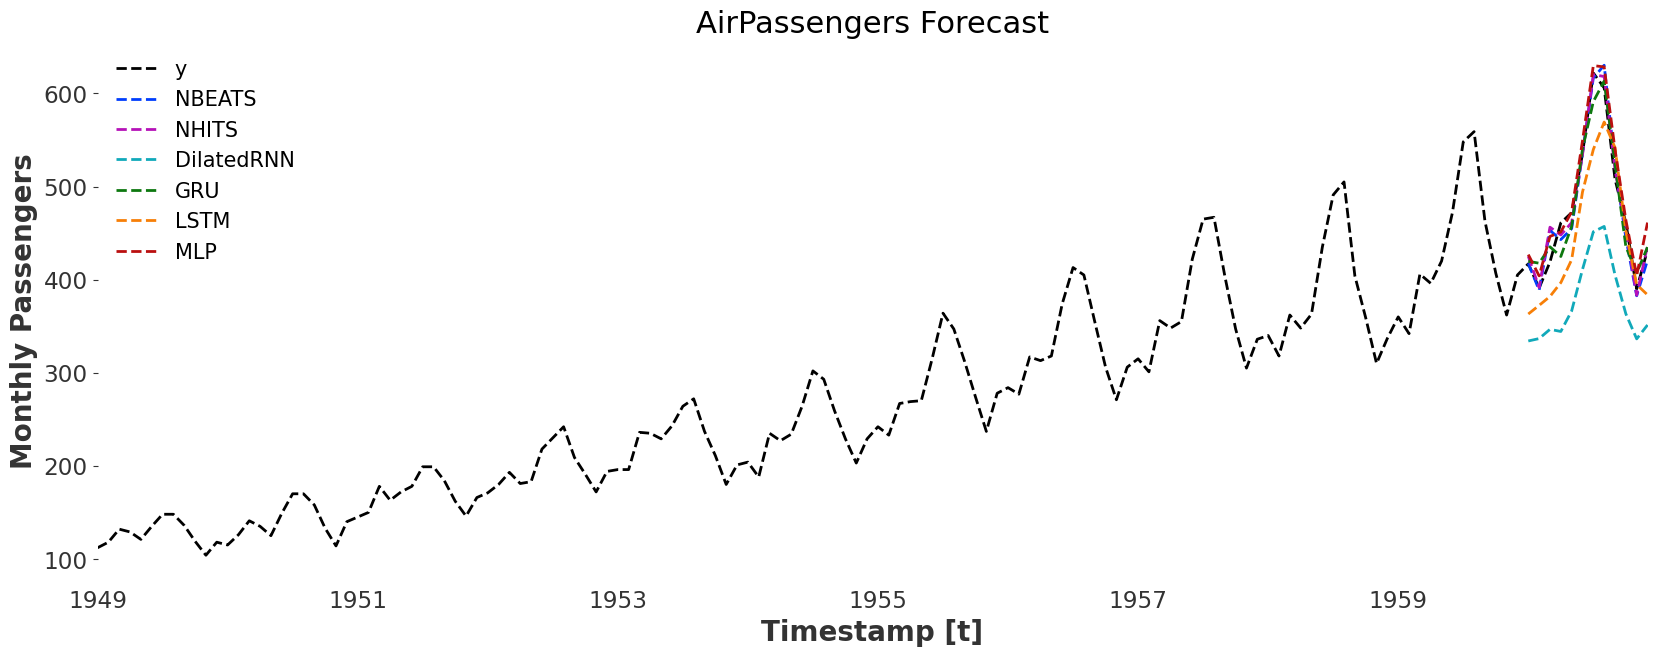

In [175]:
import pandas as pd

def plot_model_predictions(Y_train_df, Y_hat_df, Y_test_df, model_names):
    fig, ax = plt.subplots(1, 1, figsize=(20, 7))
    Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
    plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

    plot_df[['y'] + model_names].plot(ax=ax, linewidth=2)

    ax.set_title('AirPassengers Forecast', fontsize=22)
    ax.set_ylabel('Monthly Passengers', fontsize=20)
    ax.set_xlabel('Timestamp [t]', fontsize=20)
    ax.legend(prop={'size': 15})
    ax.grid()

model_names = [m.__class__.__name__ for m in models]
plot_model_predictions(Y_train_df, Y_hat_df, Y_test_df, model_names)

In [74]:
from sklearn.metrics import mean_absolute_error

metrics = {}

for m in model_names:
    metrics[m] = mean_absolute_error(Y_hat_df[m], Y_test_df["y"])
    
pd.DataFrame(dict(Neural_Forest = metrics)).T

,DilatedRNN,GRU,LSTM,MLP,NBEATS,NHITS
Neural_Forest,100.845609,16.806928,39.974047,15.362259,12.563558,9.60746


## Darts

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import (
    RNNModel, NHiTSModel, NBEATSModel, TCNModel, TFTModel, TransformerModel
)
from darts.metrics import mae  # many others available, for example mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [84]:
series = AirPassengersDataset().load()
train, val = series.split_after(pd.Timestamp("19591231"))

# normalize the data:
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# covariates with dates:
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), freq=series.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp("19590101"))


In [169]:
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
parameters = {
    "TCNModel": dict(
        input_chunk_length=24,
        output_chunk_length=12,
        n_epochs=500,
        dropout=0.1,
        dilation_base=2,
        weight_norm=True,
        kernel_size=5,
        num_filters=3,
        random_state=0,
    ),
    "RNNModel": dict(
        input_chunk_length=24,        
        hidden_dim=20,
        dropout=0,
        batch_size=16,
        n_epochs=300,
        optimizer_kwargs={"lr": 1e-3},
        log_tensorboard=True,
        random_state=42,
        training_length=10,
        force_reset=True,
        save_checkpoints=True,
    ),
    "TransformerModel": dict(
        input_chunk_length=24,
        output_chunk_length=12,
        batch_size=32,
        n_epochs=200,
        nr_epochs_val_period=10,
        d_model=16,
        nhead=8,
        num_encoder_layers=2,
        num_decoder_layers=2,
        dim_feedforward=128,
        dropout=0.1,
        activation="relu",
        random_state=42,
        save_checkpoints=True,
        force_reset=True,
    ),
    "TFTModel": dict(
        input_chunk_length=24,
        output_chunk_length=12,
        hidden_size=64,
        lstm_layers=1,
        num_attention_heads=4,
        dropout=0.1,
        batch_size=16,
        n_epochs=300,
        add_relative_index=False,
        add_encoders=None,
        likelihood=QuantileRegression(
            quantiles=quantiles
        ),  # QuantileRegression is set per default
        # loss_fn=MSELoss(),
        random_state=42,
    ),
    "NHiTSModel": dict(  # not optimized!
        input_chunk_length=24,
        output_chunk_length=12,
        num_stacks=3,
        num_blocks=1,
        num_layers=2,
        layer_widths=512,
    ),
    "NBEATSModel": dict(  # parameters not optimized!
        input_chunk_length=24,
        output_chunk_length=12,       
        generic_architecture=True,
        num_stacks=10,
        num_blocks=1,
        num_layers=4,
        layer_widths=512,
        n_epochs=100,
        nr_epochs_val_period=1,
        batch_size=800,        
    )
}

In [230]:
EPOCHS = 300
def fit_and_predict(model_class):
    def need_covariates(model_class):
        return not model_class.__name__ in [
            "NBEATSModel", "NHiTSModel", "TransformerModel", "TCNModel"
        ]
    
    print(model_class.__name__)
    params = parameters[model_class.__name__]
    my_model = model_class(
        **params,
        model_name=f"Air_{model_class.__name__}"
    )
    if need_covariates(model_class):
        my_model.fit(
            train_transformed,
            future_covariates=covariates,
            #val_series=val_transformed,
            val_future_covariates=covariates,
            verbose=True,
            epochs=EPOCHS
        )
    else:
        my_model.fit(
            train_transformed,
            #val_series=val_transformed,            
            epochs=EPOCHS,
        )
    #best_model = RNNModel.load_from_checkpoint(model_name="Air_RNN", best=True)
    pred_series = my_model.predict(
        n=12,
        future_covariates=covariates if need_covariates(model_class) else None
    )
    return pred_series


predictions = {}
for model_class in [NBEATSModel, NHiTSModel, TFTModel, TransformerModel, RNNModel, TCNModel]:
    pred_series = fit_and_predict(model_class)
    predictions[model_class.__name__] = pred_series

NBEATSModel


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

NHiTSModel


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TFTModel


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TransformerModel


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

RNNModel


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

TCNModel


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

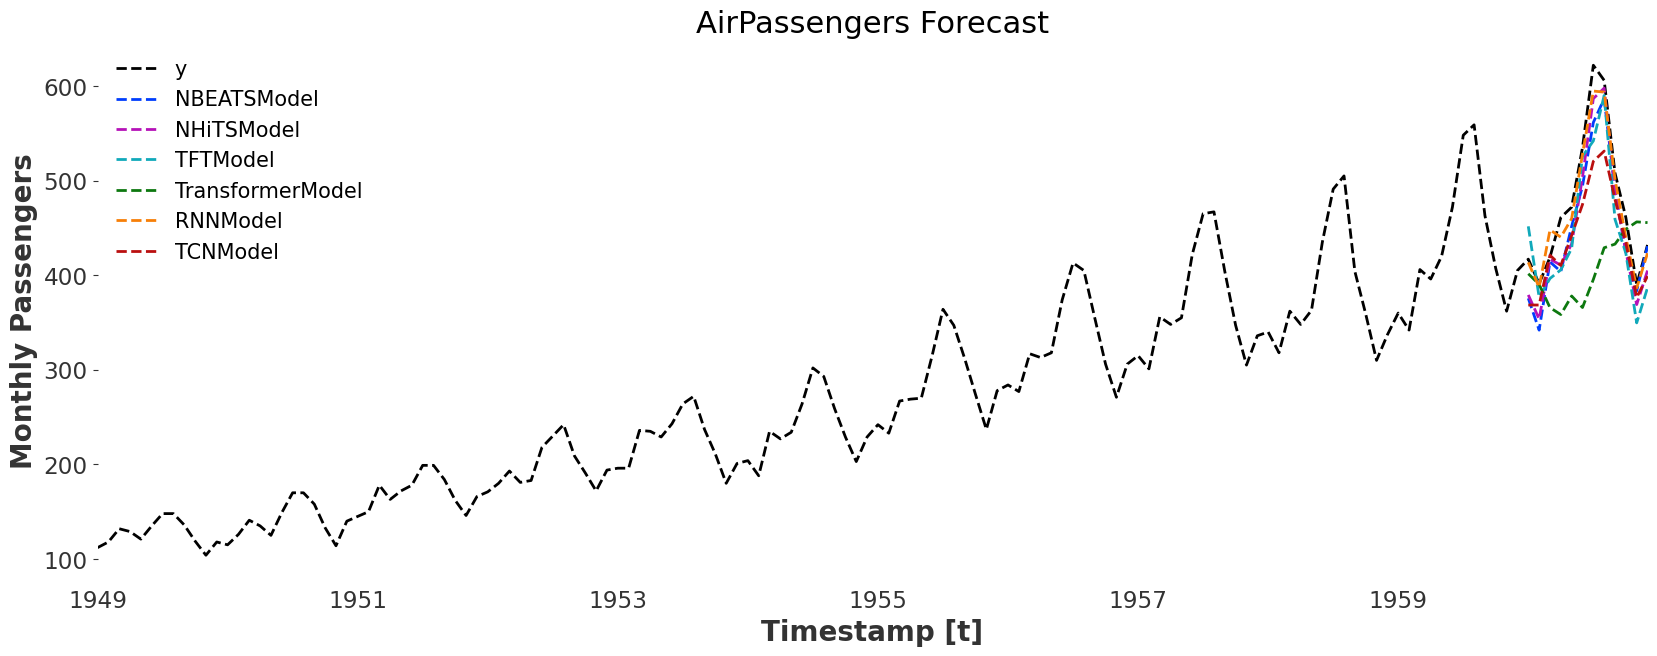

In [231]:
import numpy as np

Y_hat_darts = pd.DataFrame(
    data=np.concatenate([
        transformer.inverse_transform(vals).values() for _, vals in predictions.items()
    ], axis=1),
    columns=predictions.keys(),
).assign(unique_id=1.0, ds=Y_hat_df.ds)
model_names = list(predictions.keys())


plot_model_predictions(
    Y_train_df,
    Y_hat_darts,
    Y_test_df,
    model_names
)

In [236]:
def eval_model(pred_series):
    return mae(pred_series, val_transformed)


darts_metrics = {}    
for model_type, pred_series in predictions.items():
    darts_metrics[model_type] = eval_model(pred_series)
    
pd.DataFrame(
    dict(
        Darts=darts_metrics
    )).T

,NBEATSModel,NHiTSModel,RNNModel,TCNModel,TFTModel,TransformerModel
Darts,0.06517,0.062973,0.028526,0.089992,0.082006,0.186102
